# Introduction
In this notebook, I attempt to deconvolve the single-cell data using the freemuxlet outputs. I also take a look at the high percent mito of the data that we're seeing in some of the pools.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import seaborn as sns
import pickle as pkl
from itertools import chain
from scipy.stats import pearsonr
import os
import gzip

In [2]:
from nero import Harmonia
import seaborn as sns

In [3]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=12

In [4]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

## Load in the Data

### `h5`s and Minor Adjustments

In [5]:
aggr = sc.read_10x_h5(prefix_mrna + 'h5s/aggr/outs/filtered_feature_bc_matrix.h5').copy()
aggr.var_names_make_unique()

reading /data/clue/prod/mrna/h5s/aggr/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:24)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
bc_split = aggr.obs.index.str.split('-')
bcs = list(map(lambda x: x[0], bc_split))
gem_suffix = np.array([str(int(i) - 1) for i in list(map(lambda x: x[1], bc_split))])
aggr.obs.index = ['-'.join([i, j]) for i, j in zip(bcs,gem_suffix)]

In [7]:
wells = dict()
for well in tqdm(range(12)):
    wells[well] = dict()
    wells[well]['adata'] = aggr[gem_suffix == str(well)].copy()

  0%|          | 0/12 [00:00<?, ?it/s]

### `csv`s

In [8]:
scheme = pd.read_csv(mountpoint + 'prod/vals/scheme.csv')
postpool = pd.read_csv(mountpoint + 'prod/vals/post_pool_counts.csv')
poststim = pd.read_csv(mountpoint + 'prod/vals/post_stim.csv')

A little cleanup do get everything 0-indexed to save headaches later.

In [9]:
postpool['pool'] = [str(int(i) - 1) for i in postpool['pool']]
poststim['exp_id'] = [str(int(i) - 1) for i in poststim['exp_id']]
poststim['sample_name'] = poststim['exp_id'] + '-' + poststim['condition']

And a little more: I add an `s` to the individual numbers to not confuse them with the freemuxlet cluster IDs later on, and then make the `sample_name` the index in poststim.

In [10]:
scheme.columns = [str(i) + 's' for i in scheme.columns]
poststim.set_index('sample_name', inplace=True)

In [11]:
conds = [i for i in np.unique(scheme.values.flatten()) if i != '0']

# Cursory Filter of Genes and Cells

In [12]:
for well in tqdm(wells):
    sc.pp.filter_cells(wells[well]['adata'], min_counts=1)
    sc.pp.filter_genes(wells[well]['adata'], min_counts=1)
    wells[well]['filter_cells_n_counts'] = wells[well]['adata'].obs['n_counts'].sort_values(ascending=False)

  0%|          | 0/12 [00:00<?, ?it/s]

filtered out 9844 genes that are detected in less than 1 counts
filtered out 10067 genes that are detected in less than 1 counts
filtered out 10126 genes that are detected in less than 1 counts
filtered out 10045 genes that are detected in less than 1 counts
filtered out 9912 genes that are detected in less than 1 counts
filtered out 9468 genes that are detected in less than 1 counts
filtered out 9650 genes that are detected in less than 1 counts
filtered out 9887 genes that are detected in less than 1 counts
filtered out 9832 genes that are detected in less than 1 counts
filtered out 9818 genes that are detected in less than 1 counts
filtered out 10191 genes that are detected in less than 1 counts
filtered out 10030 genes that are detected in less than 1 counts


### Percent Mito

As can be seen below, some of our pools have a high percent mito.

In [13]:
for well in tqdm(wells):
    genelist = wells[well]['adata'].var_names.tolist()
    mito_genes_names = [gn for gn in genelist if gn.startswith('MT-')]
    mito_genes = [genelist.index(gn) for gn in mito_genes_names]
    mito_counts = np.ravel(np.sum(wells[well]['adata'][:, mito_genes].X, axis=1))
    wells[well]['adata'].obs['percent_mito'] = mito_counts / wells[well]['adata'].obs['n_counts'].values

  0%|          | 0/12 [00:00<?, ?it/s]

When writing this notebook, I visualized the histograms below, then came back here and added the next cell with cutoffs in order to get good separation of what I'm considering low and high percent mito.

In [15]:
cutoffs = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.08,0.08,0.09,0.09]

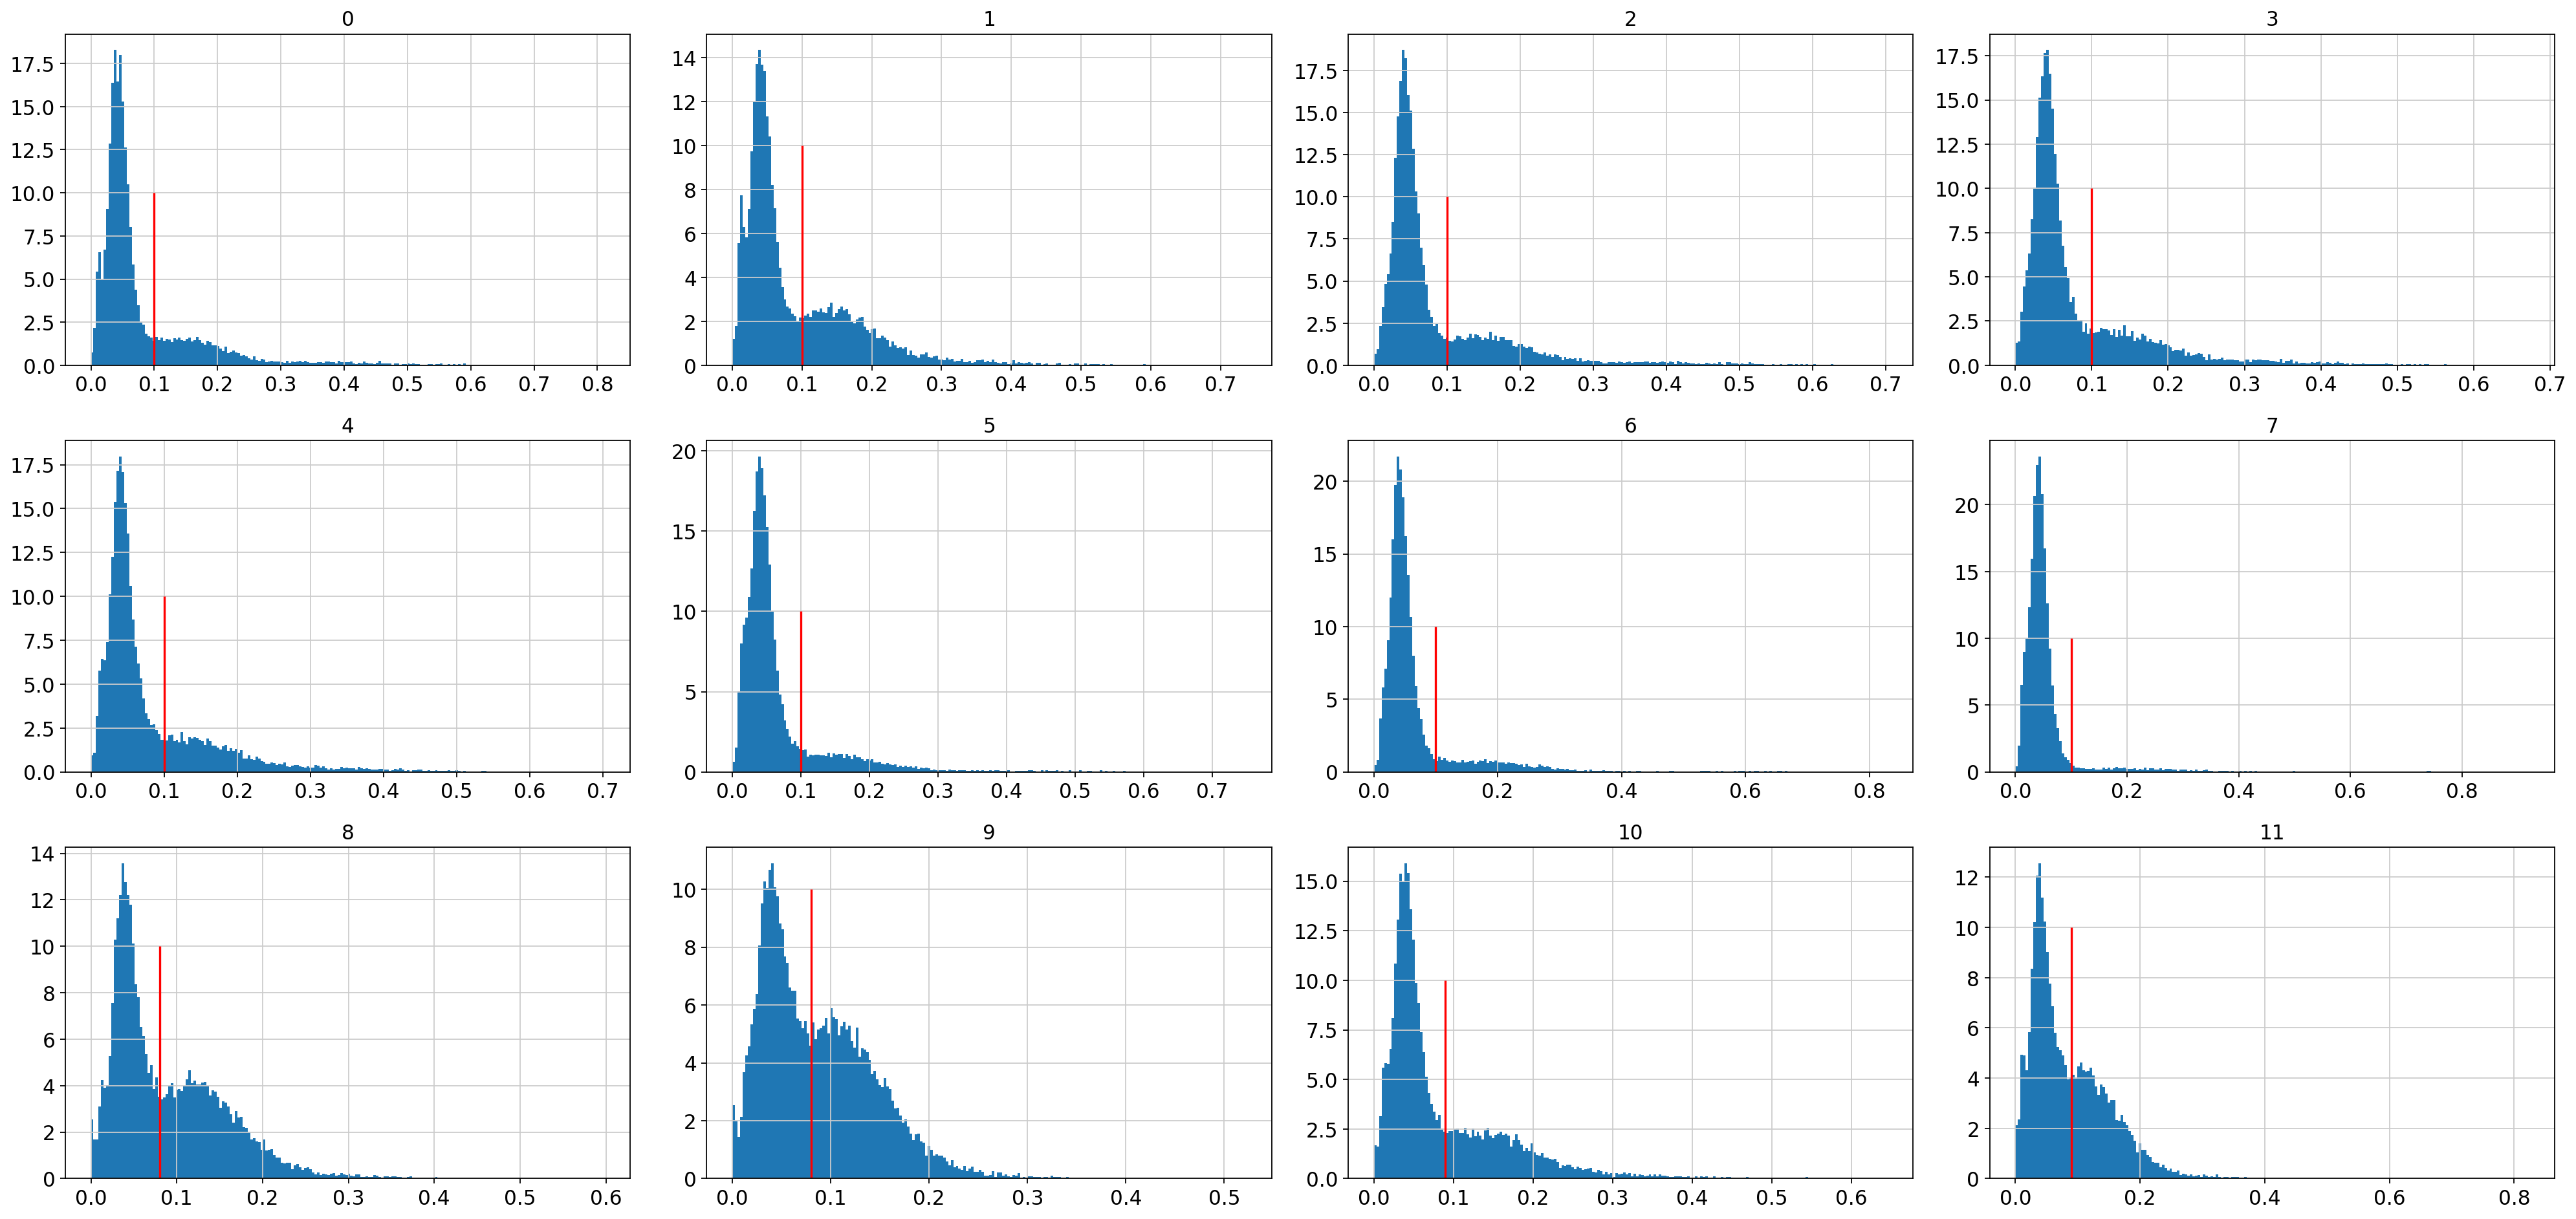

In [14]:
fig, ax = plt.subplots(3, 4, figsize=(25, 12))
for well, ax, cutoff in tqdm(zip(wells, np.ravel(ax), cutoffs)):
    ax.hist(wells[well]['adata'].obs['percent_mito'].values,bins=200,density=True);
    ax.set_title(well)
    ax.vlines(cutoff, 0, 10, color='r')
plt.tight_layout()

Just storing the percentage of cells that seem to have a high percentage of UMIs in mitochondrial genes.

In [16]:
for well, cutoff in zip(wells, cutoffs):
    wells[well]['percent_high_percent_mito'] = (wells[well]['adata'].obs['percent_mito'] > cutoff).sum()/wells[well]['adata'].shape[0]

In [17]:
path = prefix_mrna + 'pkls/wells.pkl'

# with open(path,'wb') as file:
#     pkl.dump(wells, file)
    
with open(path,'rb') as file:
    wells = pkl.load(file)

# Deconvolution

In [19]:
for well in wells:
    wells[well]['freemux'] = Harmonia.MuxOut(prefix_mrna + "demux/freemux/by_well/well%d.samples.gz" % (well + 1))

In [22]:
deconvolution = pd.DataFrame(index=range(12), columns=[str(i) + 'f' for i in range(64)], dtype=np.int)

In [23]:
for i in tqdm(deconvolution.index):
    for c in deconvolution.columns:
        deconvolution.loc[i, c] = sum(wells[i]['freemux'].sng()['BEST.GUESS'] == c[:-1]) # up until -1 to avoid the f I added

  0%|          | 0/12 [00:00<?, ?it/s]

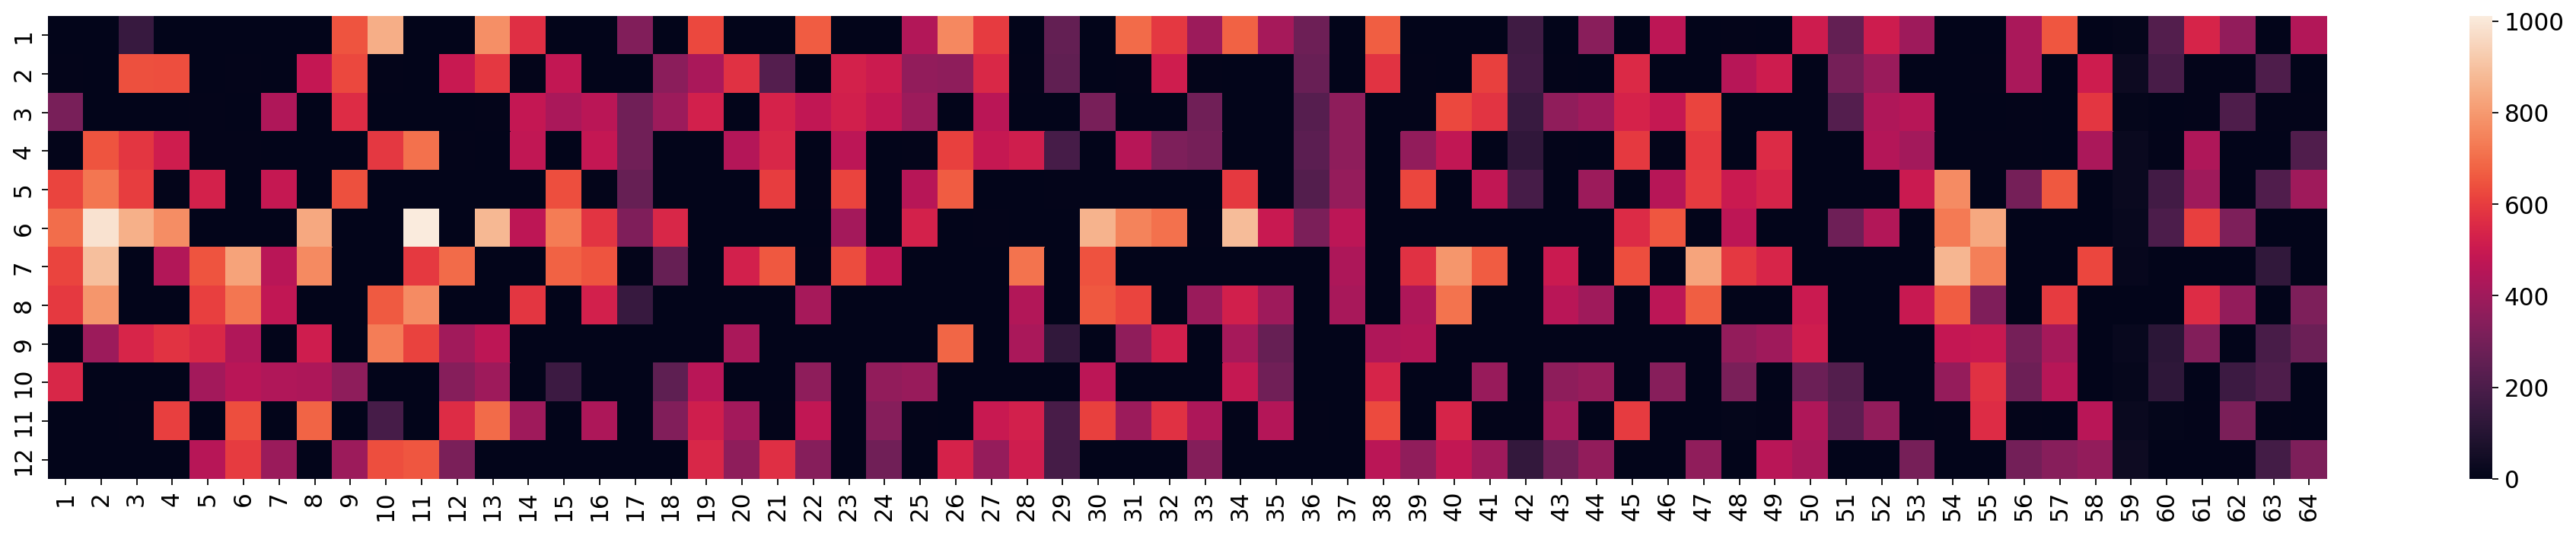

In [24]:
plt.figure(figsize=(30,5))
sns.heatmap(deconvolution);
# plt.ylabel('Well')
# plt.xlabel('Anonymous Donor');
plt.xticks(np.arange(deconvolution.shape[1]) + 0.5, deconvolution.columns.str.strip('f').astype(int) + 1);
plt.yticks(np.arange(deconvolution.shape[0]) + 0.5, deconvolution.index + 1);

In [25]:
deconvolution

,0f,1f,2f,3f,4f,5f,6f,7f,8f,9f,...,54f,55f,56f,57f,58f,59f,60f,61f,62f,63f
0,0.0,1.0,147.0,0.0,0.0,2.0,2.0,2.0,651.0,853.0,...,3.0,426.0,655.0,1.0,9.0,220.0,539.0,370.0,3.0,444.0
1,6.0,0.0,641.0,639.0,3.0,7.0,2.0,487.0,627.0,4.0,...,4.0,425.0,0.0,512.0,33.0,190.0,4.0,6.0,208.0,2.0
2,309.0,0.0,1.0,0.0,4.0,1.0,437.0,1.0,564.0,1.0,...,2.0,4.0,1.0,588.0,10.0,3.0,4.0,209.0,4.0,5.0
3,4.0,651.0,587.0,516.0,5.0,5.0,2.0,1.0,2.0,592.0,...,4.0,4.0,2.0,428.0,25.0,5.0,435.0,3.0,2.0,211.0
4,619.0,721.0,602.0,4.0,530.0,2.0,492.0,2.0,640.0,1.0,...,2.0,304.0,657.0,3.0,25.0,177.0,399.0,3.0,210.0,401.0
5,700.0,987.0,856.0,773.0,3.0,2.0,1.0,836.0,1.0,0.0,...,836.0,2.0,3.0,0.0,23.0,203.0,605.0,323.0,1.0,0.0
6,619.0,896.0,0.0,443.0,650.0,824.0,461.0,766.0,0.0,0.0,...,742.0,3.0,1.0,622.0,18.0,1.0,1.0,0.0,134.0,2.0
7,595.0,792.0,0.0,0.0,608.0,720.0,480.0,0.0,1.0,661.0,...,324.0,1.0,599.0,2.0,0.0,1.0,562.0,375.0,0.0,322.0
8,0.0,393.0,544.0,578.0,549.0,439.0,0.0,517.0,0.0,738.0,...,499.0,301.0,418.0,3.0,22.0,115.0,335.0,0.0,190.0,280.0
9,547.0,0.0,0.0,0.0,408.0,461.0,442.0,431.0,362.0,0.0,...,574.0,284.0,455.0,0.0,12.0,123.0,0.0,161.0,206.0,0.0


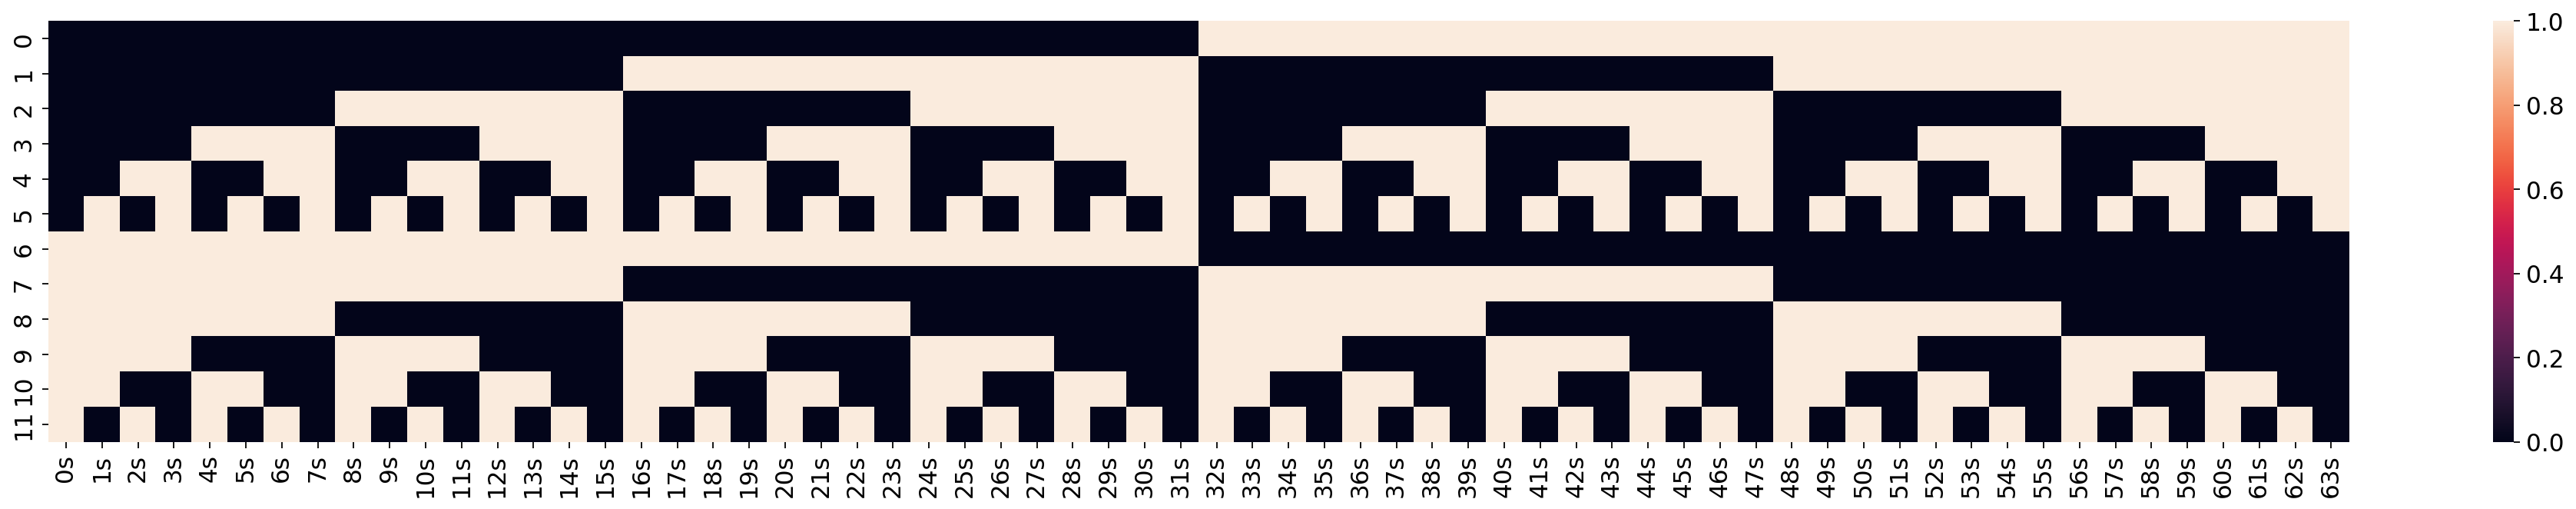

In [26]:
plt.figure(figsize=(30,4.5))
sns.heatmap(scheme != '0');

In [27]:
pool_codes_exp = dict()
pool_codes_exp_str = list()
for i in scheme.columns:
    pools = scheme[i][scheme[i] != '0'].index
    code = '-'.join(list(map(str,sorted(pools.tolist()))))
    pool_codes_exp[i] = code
    pool_codes_exp_str.append(code)
pool_codes_exp = {v: k for k, v in pool_codes_exp.items()}

In [28]:
pool_codes_free = dict()
pool_codes_free_str = list()
for i in deconvolution.columns:
    pools = deconvolution[i].sort_values(ascending=False)[:6].index
    code = '-'.join(list(map(str,sorted(pools.tolist()))))
    pool_codes_free[i] = code
    pool_codes_free_str.append(code)
pool_codes_free = {v: k for k, v in pool_codes_free.items()}

In [29]:
print(len(pool_codes_exp_str))
print(len(np.unique(pool_codes_exp_str)))

64
64


In [30]:
print(len(pool_codes_free_str))
print(len(np.unique(pool_codes_free_str)))

64
64


In [31]:
id_map_df = pd.DataFrame.from_dict(pool_codes_exp, orient='index', columns=['exp_id']).join(pd.DataFrame.from_dict(pool_codes_free, orient='index', columns=['free_id']))

In [32]:
id_map_df.iloc[5,:]

exp_id      5s
free_id    NaN
Name: 3-5-6-7-8-10, dtype: object

In [33]:
print([str(id_map_df.loc[row][0]) + ',' + str(id_map_df.loc[row][1]) for row in id_map_df.index])

['0s,5f', '1s,54f', '2s,4f', '3s,53f', '4s,27f', '5s,nan', '6s,38f', '7s,1f', '8s,42f', '9s,29f', '10s,6f', '11s,0f', '12s,39f', '13s,15f', '14s,46f', '15s,36f', '16s,11f', '17s,7f', '18s,62f', '19s,47f', '20s,19f', '21s,3f', '22s,48f', '23s,nan', '24s,23f', '25s,17f', '26s,40f', '27s,14f', '28s,57f', '29s,44f', '30s,20f', '31s,22f', '32s,49f', '33s,34f', '34s,56f', '35s,33f', '36s,9f', '37s,30f', '38s,63f', '39s,60f', '40s,21f', '41s,61f', '42s,43f', '43s,45f', '44s,32f', '45s,13f', '46s,52f', '47s,16f', '48s,37f', '49s,12f', '50s,55f', '51s,59f', '52s,28f', '53s,31f', '54s,25f', '55s,2f', '56s,18f', '57s,50f', '58s,8f', '59s,24f', '60s,26f', '61s,51f', '62s,41f', '63s,35f']


In [34]:
print(sorted([int(i[:-1]) for i in id_map_df['free_id'].dropna()]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63]


Missing 10 and 58. Freemuxlet 10 is probably supposed to be 5, considering its only off by 1 from the 5 code and 5 is missing, which would leave 58 to be 23.

In [35]:
id_map_df['free_id'].iloc[5] = '10f'

In [36]:
id_map_df['free_id'].iloc[23] = '58f'

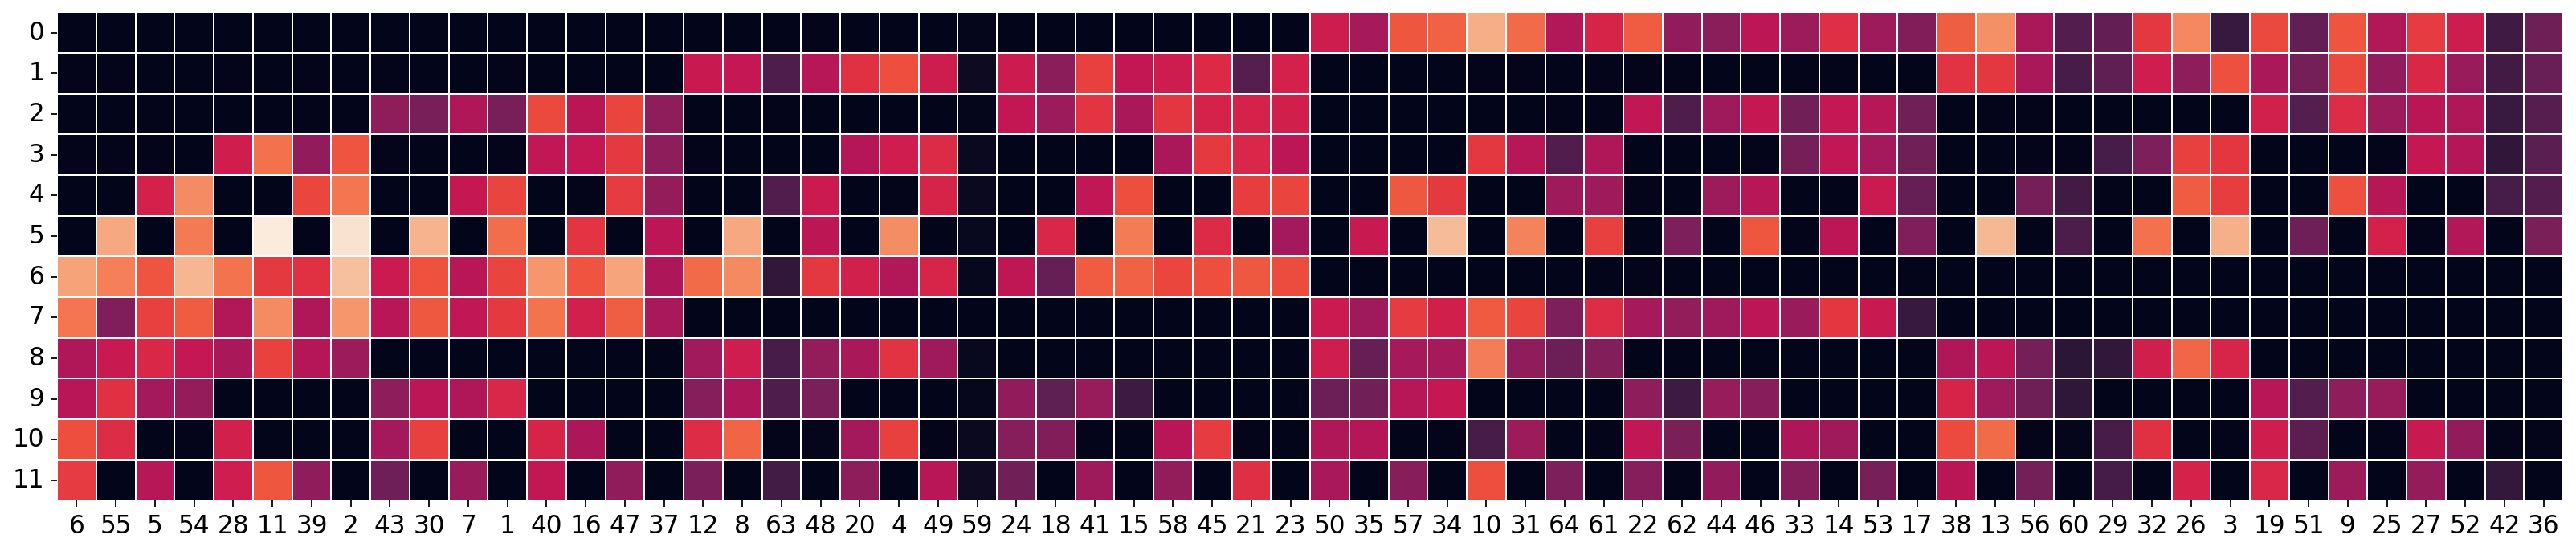

In [37]:
plt.figure(figsize=(25,5))
deconvolution_ordered = deconvolution[id_map_df['free_id'].values]
sns.heatmap(deconvolution_ordered, cbar=None, linewidth=0.5);
# plt.ylabel('Well')
# plt.xlabel('Anonymous Donor');
plt.xticks(np.arange(deconvolution_ordered.shape[1]) + 0.5, deconvolution_ordered.columns.str.strip('f').astype(int) + 1, rotation=0);
plt.yticks(np.arange(deconvolution_ordered.shape[0]) + 0.5, deconvolution_ordered.index, rotation=0);


In [38]:
with open(mountpoint + 'cond_colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['rgb']

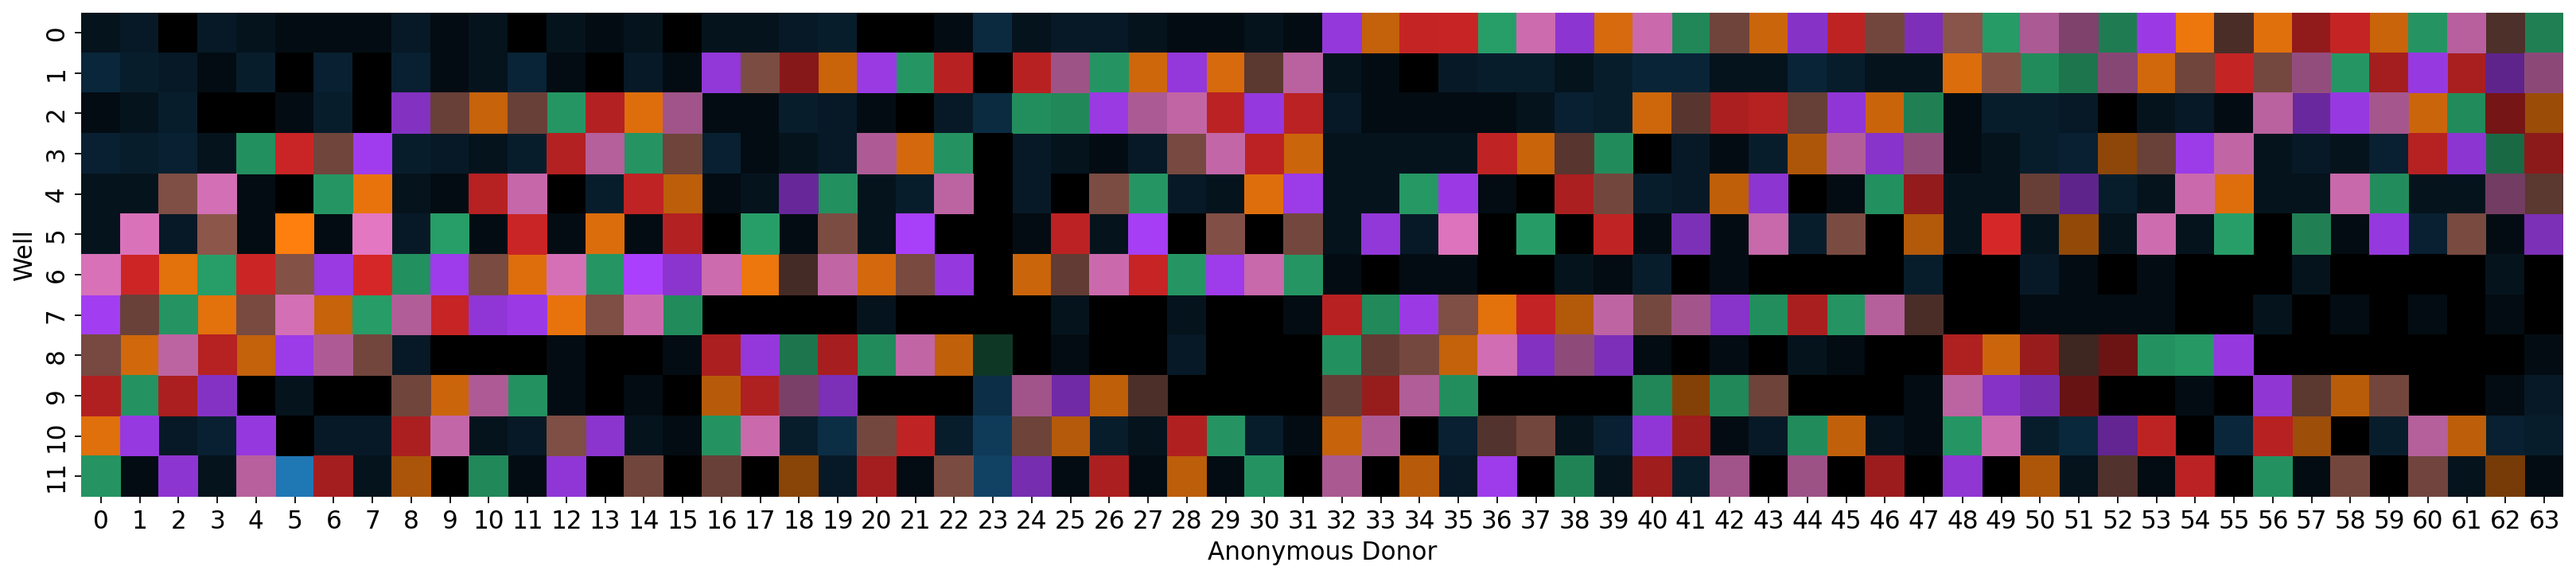

In [39]:
fig, ax = plt.subplots(1,1, figsize=(25, 5))
for color in cond_colors:
    ax = sns.heatmap(np.where(scheme == color, np.log(deconvolution[id_map_df['free_id'].values] + 1), np.nan), cbar=False,
                     cmap = mpl.colors.LinearSegmentedColormap.from_list(color, [[0,0,0],cond_colors[color]], N=100))
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

In [40]:
cond_colors['0'] = (1, 1, 1)

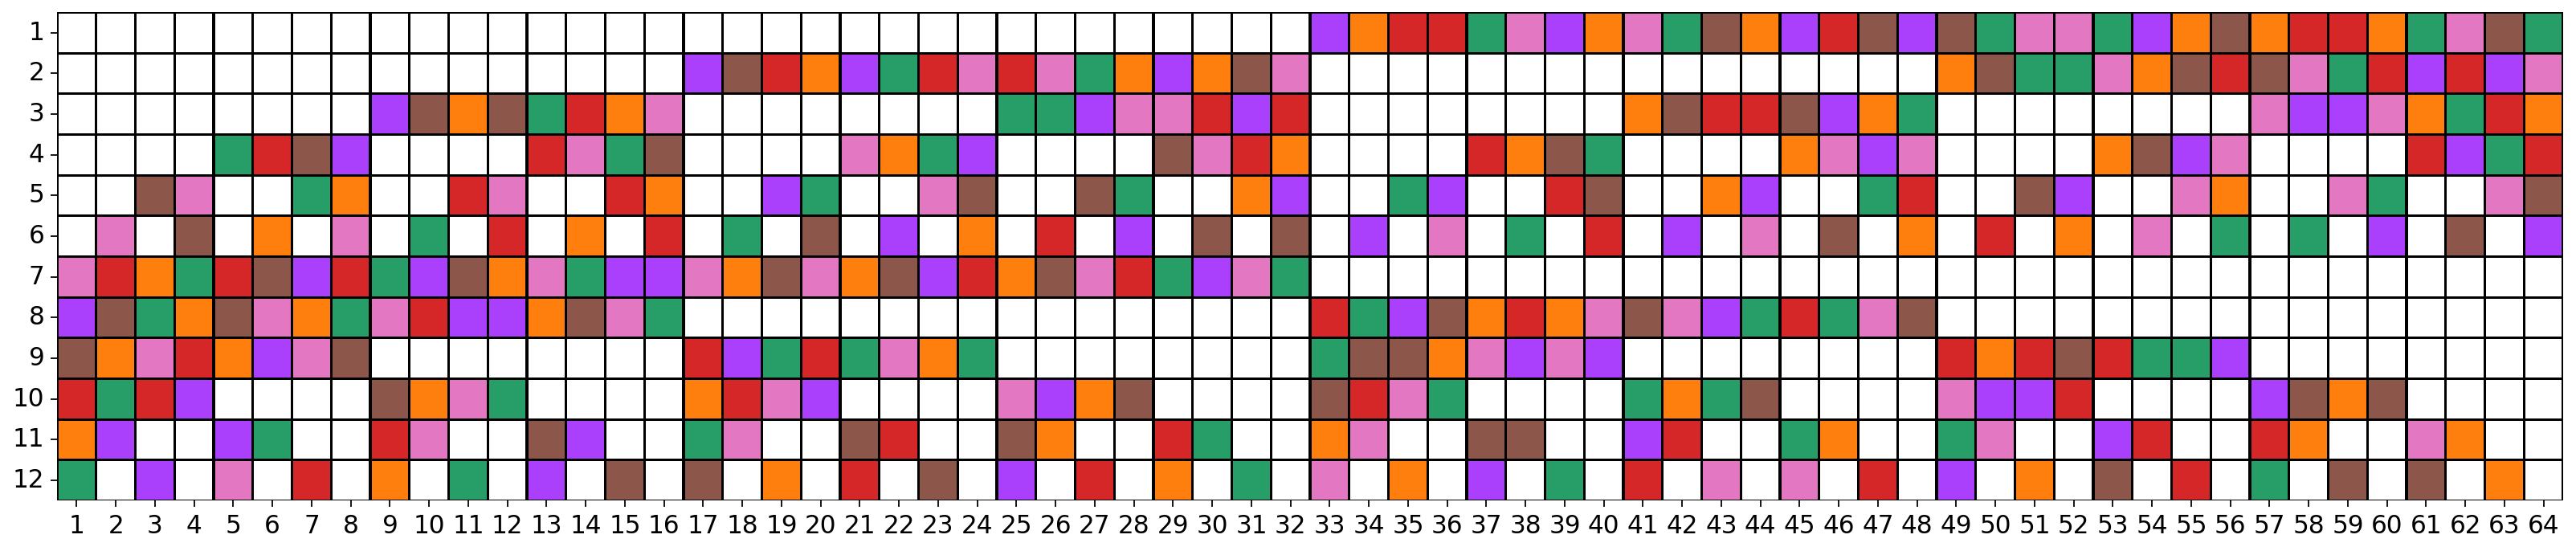

In [41]:
fig, ax = plt.subplots(1,1, figsize=(25, 5))
for color in cond_colors:
    ax = sns.heatmap(np.where(scheme == color, scheme != 0, np.nan), cbar=False, linewidth=1, linecolor='k',
                     cmap = [cond_colors[color]])
plt.xticks(np.arange(deconvolution.shape[1]) + 0.5, deconvolution.columns.str.strip('f').astype(int) + 1, rotation=0);
plt.yticks(np.arange(deconvolution.shape[0]) + 0.5, deconvolution.index + 1, rotation=0);

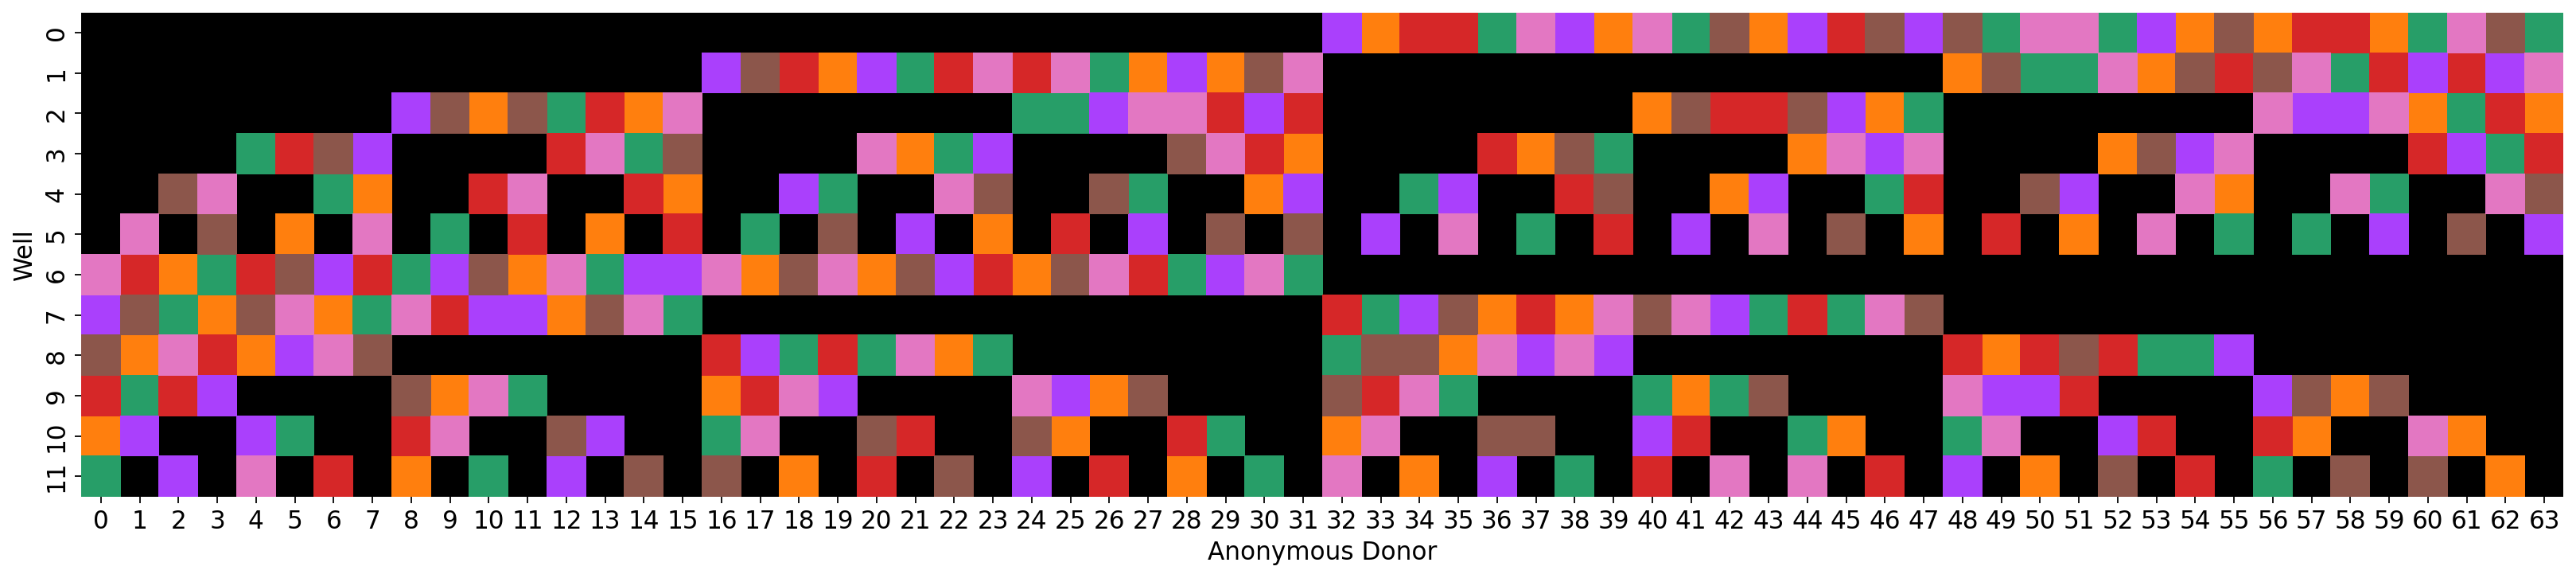

In [42]:
fig, ax = plt.subplots(1,1, figsize=(25, 5))
for color in cond_colors:
    if color == '0':
        ax = sns.heatmap(np.where(scheme == color, scheme != 0, np.nan), cbar=False,
                         cmap = [[0,0,0]])
    else:
        ax = sns.heatmap(np.where(scheme == color, scheme != 0, np.nan), cbar=False,
                         cmap = [cond_colors[color]])
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

## Investigating High Percent Mito

Trying to see if it can be explained by any of the experimental variables we have from the day of the experiment.

### Viability (Countess) of each pool just before loading

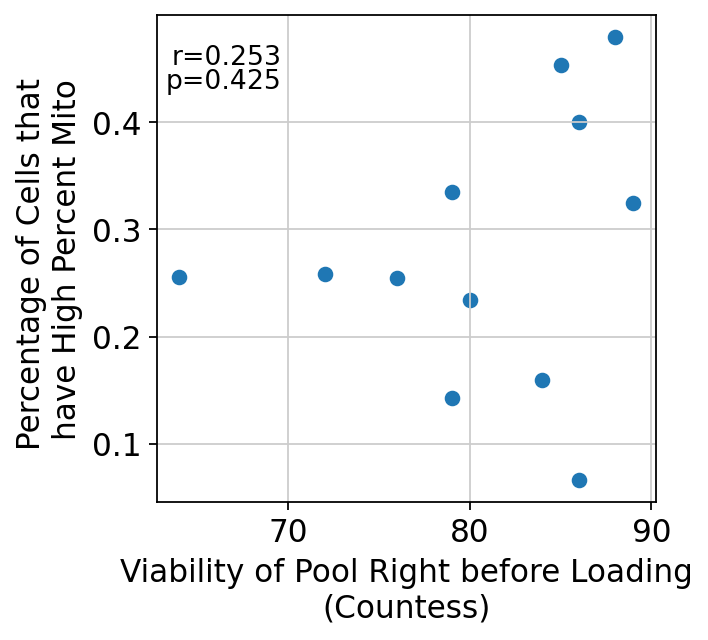

In [44]:
exp_viabilities = postpool[postpool['count_type'] == 'post_flowmi']['viability'].values
high_mitos = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
plt.scatter(exp_viabilities, high_mitos);
r, p = pearsonr(exp_viabilities,high_mitos)
ax = plt.gca()
plt.text(0.25,0.9, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
plt.text(0.25,0.85, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')
plt.ylabel('Percentage of Cells that \nhave High Percent Mito')
plt.xlabel('Viability of Pool Right before Loading\n(Countess)');

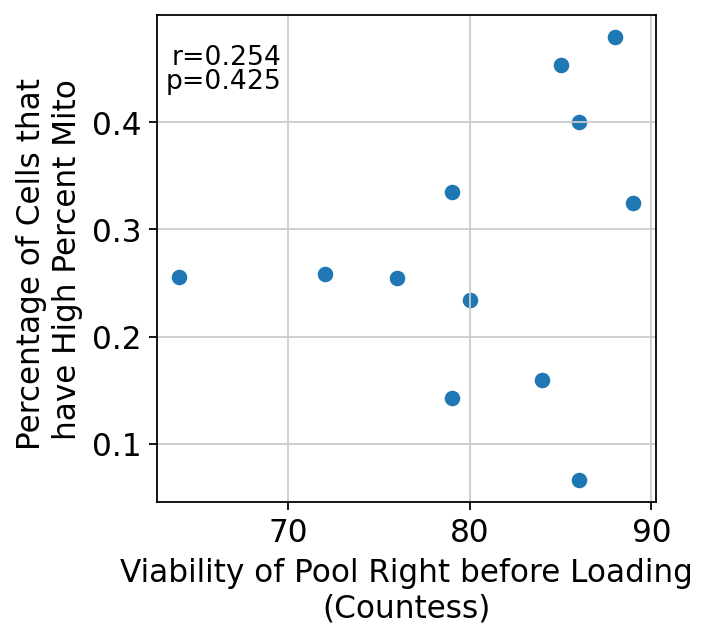

In [37]:
exp_viabilities = postpool[postpool['count_type'] == 'post_flowmi']['viability'].values
high_mitos = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
plt.scatter(exp_viabilities, high_mitos);
r, p = pearsonr(exp_viabilities,high_mitos)
ax = plt.gca()
plt.text(0.25,0.9, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
plt.text(0.25,0.85, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')
plt.ylabel('Percentage of Cells that \nhave High Percent Mito')
plt.xlabel('Viability of Pool Right before Loading\n(Countess)');

### Average viability (FACS) of the samples that were destined for each pool right after stim incubation

In [45]:
samps = dict()

In [46]:
for pool in scheme.index:
    samps[pool] = list()
    for ind in scheme.columns:
        if scheme.loc[pool,ind] != '0':
            samps[pool].append(str(ind) + '-' + scheme.loc[pool,ind])
            

In [47]:
mean_viablities = list()
for pool in range(12):
    counted = np.intersect1d(poststim.index.values, 
                             [i.replace('s','') for i in samps[pool]], # need to do this because I added an "s" to the IDs
                             assume_unique=True
                            )
    mean_viablities.append(poststim.loc[counted,:].mean()['viability'])

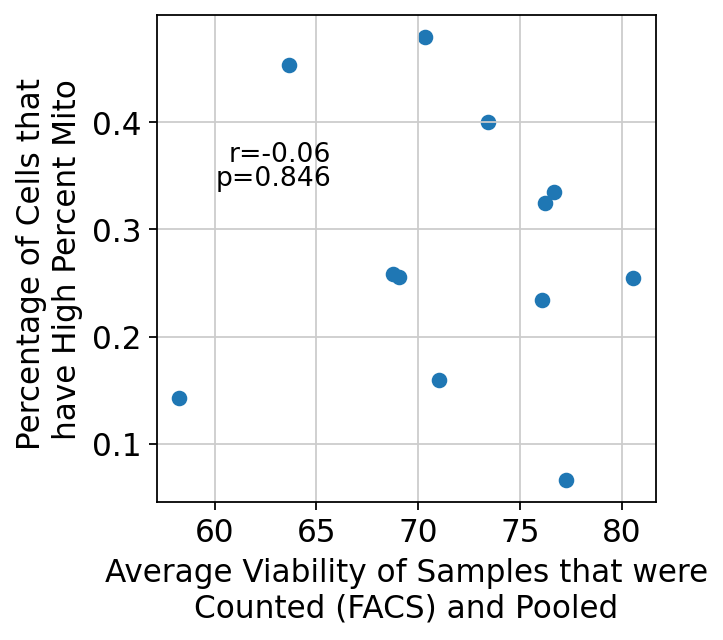

In [48]:
x = mean_viablities
y = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
plt.scatter(x, y);
r, p = pearsonr(x,y)
ax = plt.gca()
plt.text(0.35,0.7, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
plt.text(0.35,0.65, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')
plt.ylabel('Percentage of Cells that \nhave High Percent Mito')
plt.xlabel('Average Viability of Samples that were\nCounted (FACS) and Pooled');

### Percentage of cells in the pool from a given condition

Checking to see if its also possibly due to overrepresentation of any one condition.

In [55]:
cond_count = pd.DataFrame(index=range(12),columns=conds, dtype=np.int)

In [56]:
for pool in tqdm(range(12)):
    for cond in conds:
        cond_count.loc[pool, cond] = deconvolution_ordered.loc[pool][(scheme==cond).values[pool]].sum()

  0%|          | 0/12 [00:00<?, ?it/s]

In [57]:
bool_mask_low_high = np.any(np.stack([cond_count.values == cond_count.values.min(), 
                                      cond_count.values == cond_count.values.max()]), 
                            axis=0, keepdims=False)

In [58]:
annot = np.where(bool_mask_low_high, cond_count.values.astype(np.int), '')

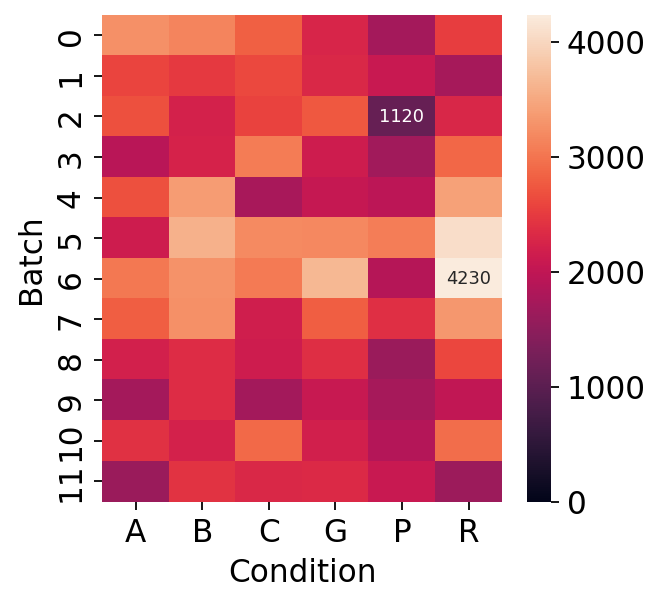

In [59]:
sns.heatmap(cond_count, vmin=0, annot=annot, fmt='', annot_kws={'fontsize':8}); 
plt.xlabel('Condition');
plt.ylabel('Batch');

In [60]:
cond_props = cond_count.divide(cond_count.sum(1), axis='index')

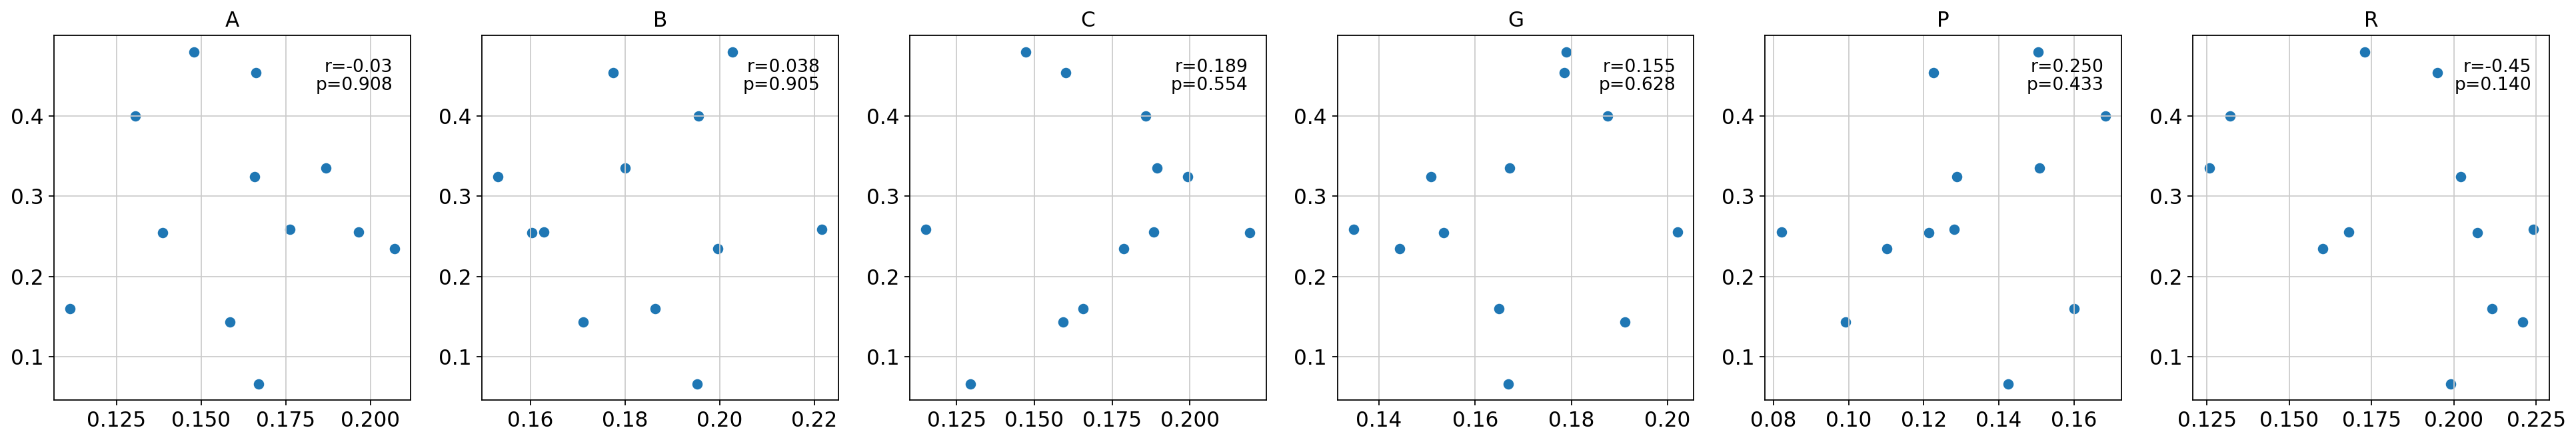

In [61]:
fig, ax = plt.subplots(1,6,figsize=(30,4.5))
for cond, ax in zip(conds, ax):
    x = cond_props[cond].values
    y = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
    ax.scatter(x,y)
    ax.set_title(cond)
    r, p = pearsonr(x,y)
    ax.text(0.95,0.9, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
    ax.text(0.95,0.85, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')

## Plotting Conditions

Visualizing the number of cells per condition.

To keep colors consistent across all figures, I'm going to load in our color dictionary:

In [50]:
with open(mountpoint + 'cond_colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['rgb']

In [51]:
deconvolution_ordered = deconvolution[id_map_df['free_id'].values]

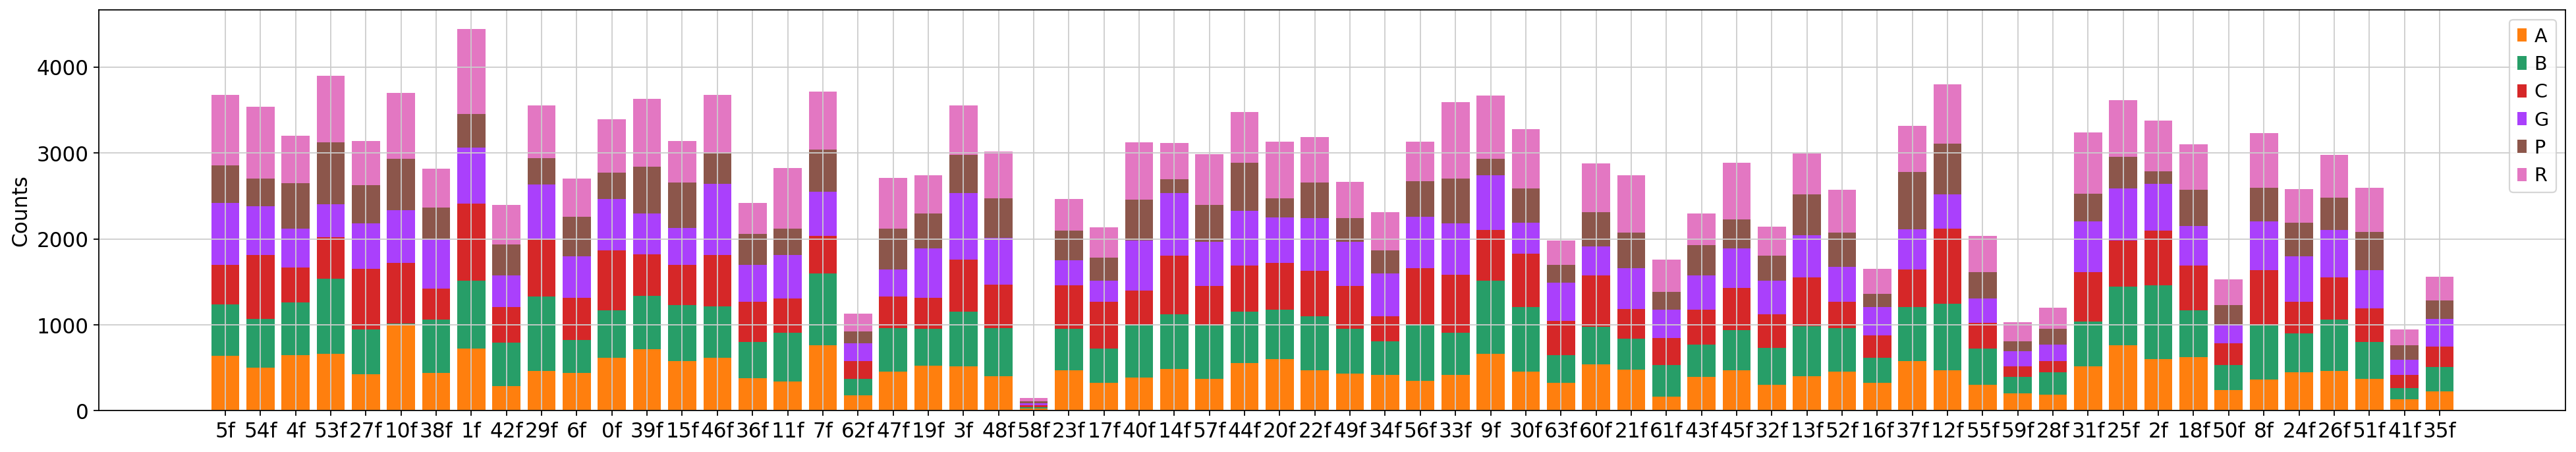

In [52]:
labels = deconvolution_ordered.columns.values
counts = dict()

for cond in conds:
    counts[cond] = deconvolution_ordered.values.T[(scheme==cond).values.T]

fig, ax = plt.subplots(figsize=(30,5))
lastpos = [0]*64
for cond in counts:
    ax.bar(labels, counts[cond], label=cond, bottom=lastpos, color=cond_colors[cond])
    lastpos = counts[cond] + lastpos

ax.set_ylabel('Counts')
ax.legend()

plt.show()

In [53]:
keys, values = map(chain.from_iterable, zip(*((k*len(v), v) for k, v in counts.items())))
counts_df = pd.DataFrame({'cond': list(keys), 'count': list(values)})

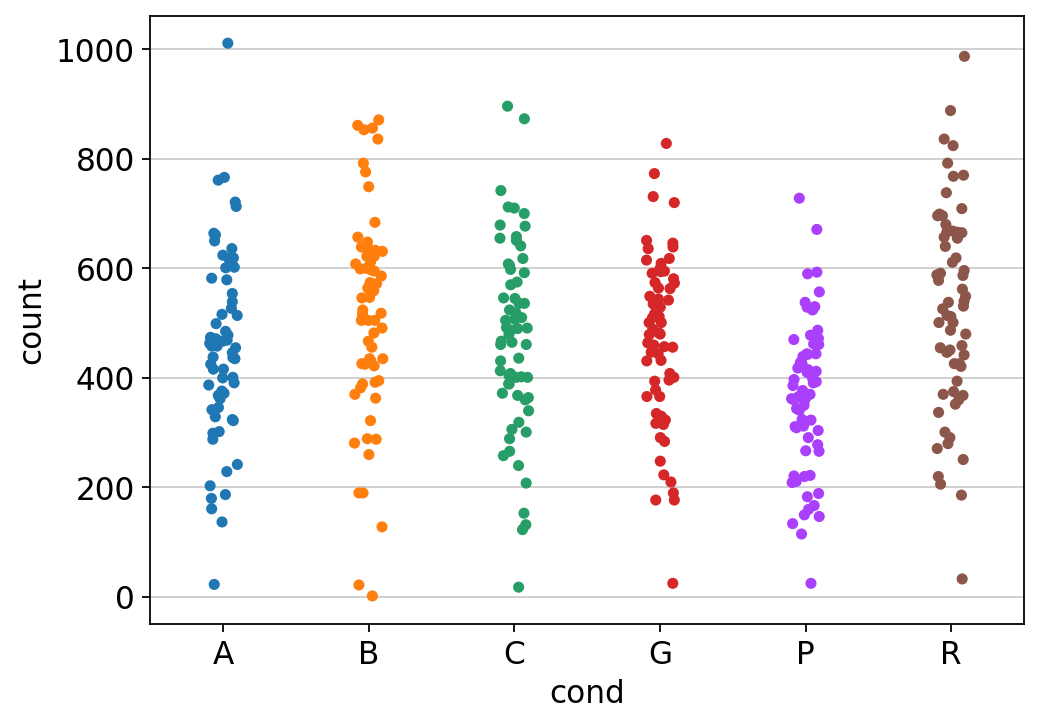

In [54]:
plt.figure(figsize=(7,5))
sns.stripplot(data=counts_df,x='cond',y='count');

# Attach Covariates

In [62]:
id_map_df['pool_code'] = id_map_df.index
id_map_df.set_index('free_id', inplace=True)
id_map_df.index = [i.strip('f') for i in id_map_df.index]

In [63]:
id_map_df['exp_id'] = id_map_df['exp_id'].str.replace('s','')

In [64]:
id_maps = dict()

In [65]:
for pool in scheme.index:
    cond_series = scheme.loc[pool]
    cond_series.index = cond_series.index.str.replace('s','')
    pool_df = id_map_df.copy()
    pool_df['cond'] = pool_df['exp_id'].map(dict(cond_series)).tolist()
    # proud of the next two lines
    pool_df['viability_sample'] = (pool_df['exp_id'] + '-' + pool_df['cond']).map(dict(zip(poststim.index,poststim['viability'])))
    pool_df['viability_eq_ctrl'] = (pool_df['exp_id'] + '-C').map(dict(zip(poststim.index,poststim['viability'])))
    id_maps[pool] = pool_df

In [70]:
wells[11]['adata'].obs

,n_counts,percent_mito
AAACCCAAGAAATGGG-11,5206.0,0.037841
AAACCCAAGGCTTTCA-11,864.0,0.024306
AAACCCACAATAGTCC-11,5674.0,0.054635
AAACCCACACCTCTAC-11,5963.0,0.060875
AAACCCACAGACAAAT-11,4839.0,0.059310
...,...,...
TTTGTTGTCGAACCTA-11,6368.0,0.102073
TTTGTTGTCGAGTGGA-11,17877.0,0.063042
TTTGTTGTCGATACAC-11,2952.0,0.217818
TTTGTTGTCGTCTCAC-11,7410.0,0.043185


In [71]:
new_obs = pd.concat([wells[well]['adata'].obs, wells[well]['freemux'].sng()], axis=1, join='inner')

In [72]:
for well in tqdm(wells):
    bc_split = wells[well]['freemux'].data.index.str.split('-')
    bcs = list(map(lambda x: x[0], bc_split))
    gem_suffix = np.array([str(well) for i in list(map(lambda x: x[1], bc_split))])
    wells[well]['freemux'].data.index = ['-'.join([i, j]) for i, j in zip(bcs,gem_suffix)]

  0%|          | 0/12 [00:00<?, ?it/s]

In [73]:
for well in tqdm(wells):
    wells[well]['adata'] = Harmonia.ann_merge(wells[well]['adata'], wells[well]['freemux'].sng(), covars=id_maps[well])
    wells[well]['adata'].obs.columns = wells[well]['adata'].obs.columns.str.replace('BEST.GUESS','free_id')

  0%|          | 0/12 [00:00<?, ?it/s]

In [74]:
for well in wells:
    print((wells[well]['adata'].obs['cond'] == 'C').sum())

2811
2623
2570
3057
1757
3191
3047
2170
2132
1712
2895
2308


In [75]:
wells[well]['adata'].obs

,n_counts,percent_mito,NUM.SNPS,NUM.READS,DROPLET.TYPE,free_id,exp_id,pool_code,cond,viability_sample,viability_eq_ctrl
AAACCCAAGAAATGGG-11,5206.0,0.037841,535,810,SNG,9,36,0-3-7-8-10-11,G,NaN,85.4
AAACCCACAATAGTCC-11,5674.0,0.054635,588,861,SNG,19,20,1-3-6-8-10-11,C,59.3,59.3
AAACCCACACCTCTAC-11,5963.0,0.060875,616,1100,SNG,20,30,1-2-3-4-6-11,B,NaN,84.3
AAACCCACAGACAAAT-11,4839.0,0.059310,624,962,SNG,19,20,1-3-6-8-10-11,C,59.3,59.3
AAACCCACAGGGCTTC-11,5840.0,0.019178,614,1161,SNG,28,52,0-1-3-8-10-11,P,51.2,30.0
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTAGGCTT-11,4565.0,0.040526,485,801,SNG,57,28,1-2-3-6-10-11,A,NaN,78.9
TTTGTTGTCACTAGCA-11,3259.0,0.037128,363,469,SNG,38,6,3-4-6-7-8-11,C,68.4,68.4
TTTGTTGTCCGCTAGG-11,8346.0,0.049844,842,1722,SNG,63,38,0-3-4-7-8-11,B,NaN,65.8
TTTGTTGTCGAGTGGA-11,17877.0,0.063042,1440,3945,SNG,55,50,0-1-4-8-9-11,A,NaN,57.3


In [76]:
wells[well]['adata']

AnnData object with n_obs × n_vars = 13137 × 23508
    obs: 'n_counts', 'percent_mito', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'free_id', 'exp_id', 'pool_code', 'cond', 'viability_sample', 'viability_eq_ctrl'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

# Export

In [78]:
path = prefix_mrna + 'pkls/wells_sng_covars.pkl'

# with open(path,'wb') as file:
#     pkl.dump(wells, file)
    
with open(path,'rb') as file:
    wells = pkl.load(file)